# Simple End to End Demo

Welcome to the end to end demo of LightweigthMMM. This is a very simple demo in 
which we showcase the basic usage and functionalities of the library.

Disclaimer: This notebooks skips all exploratory data analysis and preprocessing (besides scaling) and assumes the user will do or has done it prior to engaging this point of the demo.

This notebook uses dummy data and therefore the numbers and results might not be representative of what one might get on a real dataset.

For running chains in parallel you can set the number of CPUs at the begining of the program like the following:
`numpyro.set_host_device_count(n)`

In [ ]:
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro

In [ ]:
# First would be to install lightweight_mmm
!pip install --upgrade git+https://github.com/google/lightweight_mmm.git

In [ ]:
# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

## Organising the data for modelling

In [ ]:
SEED = 105
N_CHAINS = 2
# numpyro.set_host_device_count(N_CHAINS)

In [ ]:
data_size = 104 + 13
n_media_channels = 3
n_extra_features = 1

In [ ]:
media_data, extra_features, target, costs = utils.simulate_dummy_data(
    data_size=data_size,
    n_media_channels=n_media_channels,
    n_extra_features=n_extra_features)

We can then split the dataset into train and test. Lets leave only the last 13 weeks for testing in this case.

In [ ]:
# Split and scale data.
split_point = data_size - 13
# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]
# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]
# Target
target_train = target[:split_point]

Scaling is essential for many modelling problems and this one is no exception.

We provide the class `CustomScaler` which behaves accordingly with `sklearn`
scalers.

In most cases you will need 3 or 4 scalers. One scaler for the media data, one
for the target and one for costs. Optionally if you are adding extra features
those might need an extra scaler. **It is very important that you save and
"carry with you" those scalers throughout your MMM journey as LighweightMMM will
allow you to re-insert these scalers at different points to ensure everything is
always in the correct scale and results. If some results don't make sense, it
might be a scaling problem.**

A few more details on CustomScaler usage:

This scaler can be used in two fashions for both the multiplication and division
operation. 
- By specifying a value to use for the scaling operation. 
- By specifying an operation used at column level to calculate the value for the
actual scaling operation.

Eg. if one wants to scale the dataset by multiply by 100 you can directly pass
multiply_by=100. Value can also be an array with as many values as column has
the data being scaled. But if you want to multiply by the mean value of each
column, then you can pass multiply_operation=jnp.mean (or any other operation
desired).

Operation parameters have the upper hand in the cases where both values and
operations are passed, values will be ignored in this case.

Consult the full class documentation if you still need to know more.

In [ ]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

### Training the model

The currently available models are the following: 
- hill_adstock 
- adstock 
- carryover

In [ ]:
mmm = lightweight_mmm.LightweightMMM(model_name="carryover")

Training the model will require the following mandatory parameters: 
- media
- total_costs (one value per channel) 
- target

We can optionally also pass the following: 
- extra_features: Other variables to add to the model. 
- degrees_seasonality: Number of degrees to use for seasonality. Default is 3. 
- seasonality_frequency: Frequency of the time period used. Default is 52 as in 52 weeks per year. 
- media_names: Names of the media channels passed. 
- number_warmup: Number of warm up samples. Default is 1000. 
- number_samples: Number of samples during sampling. Default is 1000. 
- number_chains: Number of chains to sample. Default is 2.

In [ ]:
number_warmup=2000
number_samples=2000

In [ ]:
# For replicability in terms of random number generation in sampling
# reuse the same seed for different trainings.
mmm.fit(
    media=media_data_train,
    total_costs=costs,
    target=target_train,
    extra_features=extra_features_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    number_chains=N_CHAINS,
    seed=SEED)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

You can check the summary of your trace by printing a summary:

In [ ]:
mmm.print_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.31      0.17      0.31      0.04      0.58    559.22      1.00
ad_effect_retention_rate[1]      0.44      0.29      0.42      0.00      0.88    528.17      1.00
ad_effect_retention_rate[2]      0.30      0.21      0.27      0.00      0.59    357.80      1.01
     beta_extra_features[0]     -0.04      0.01     -0.04     -0.07     -0.02    634.80      1.01
              beta_media[0]      0.15      0.05      0.15      0.07      0.24    343.23      1.00
              beta_media[1]      0.02      0.02      0.01      0.00      0.04    682.32      1.00
              beta_media[2]      0.10      0.05      0.10      0.01      0.16    193.50      1.01
                 beta_trend     -0.00      0.00     -0.00     -0.00      0.00    682.73      1.00
                 expo_trend      0.15      0.15      0.09      0.00      0.34    432.14      1.00
                exp

We can visualise the posterior distributions of the media effects:

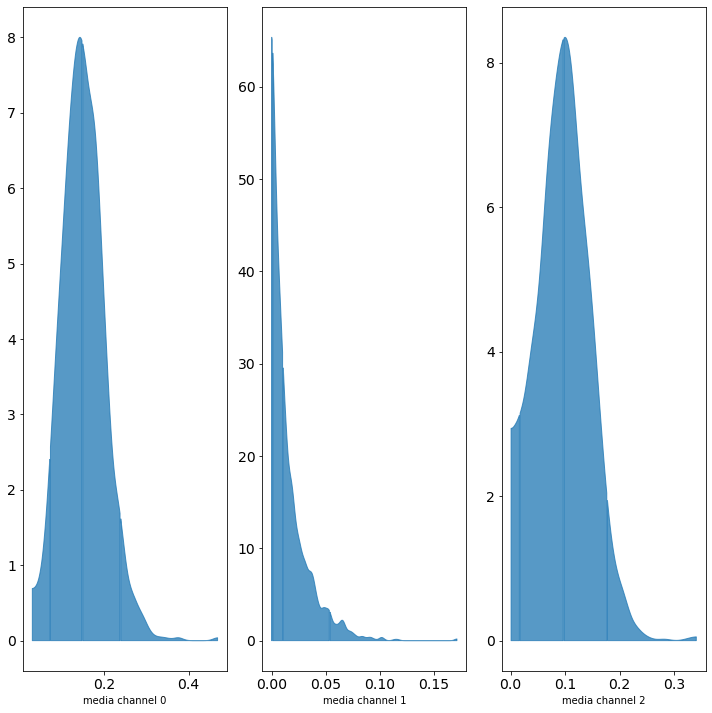

In [ ]:
plot.plot_media_channel_posteriors(media_mix_model=mmm)

One can also check your model's fit to the training data.

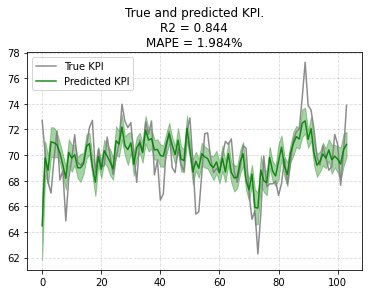

In [ ]:
# Here is another example where we can pass the target scaler if you want the plot to be in the "not scaled scale"
plot.plot_model_fit(mmm, target_scaler=target_scaler)

If one wants to run predictions on unseen data they can rely on the `predict`
method:

In [ ]:
# We have to scale the test media data if we have not done so before.
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test),
                              extra_features=extra_features_scaler.transform(extra_features_test),
                              seed=SEED)
new_predictions.shape

(2000, 13)

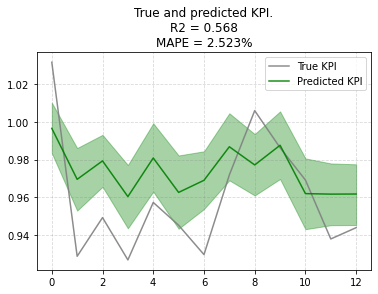

In [ ]:
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target[split_point:]))

### Media insights

In [ ]:
preds, media_effect, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

We can quickly visualise the estimated media effects with their respective
credibility intervals

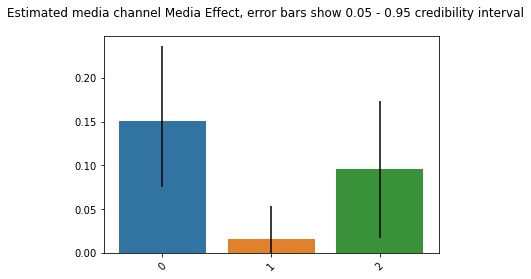

In [ ]:
plot.plot_bars_media_metrics(metric=media_effect, metric_name="Media Effect")

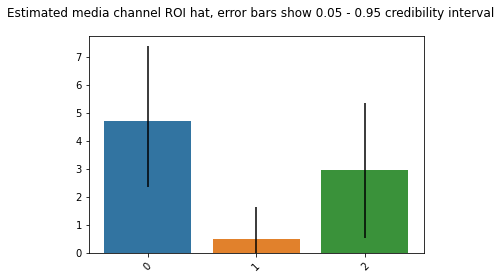

In [ ]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat")

Another vital question we can solve with MMMs is how each media channel behaves
individually as we invest more in it.

For that we can plot the curve response of all media channels with the following
function:

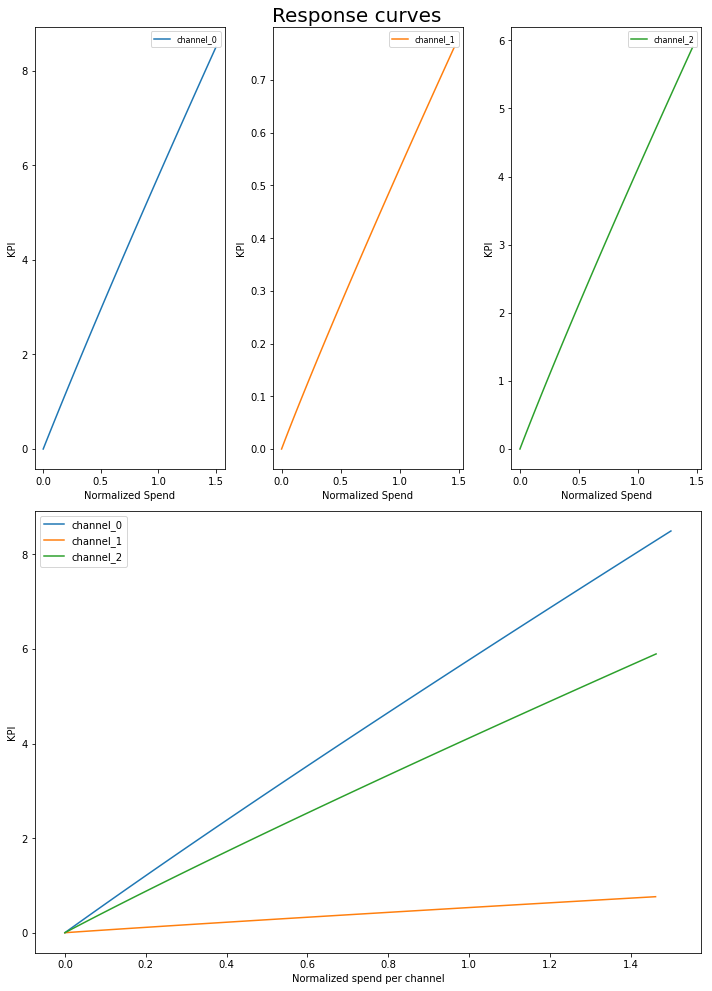

In [ ]:
plot.plot_response_curves(
    media_mix_model=mmm, target_scaler=target_scaler, seed=SEED)

### Optimization

The optimization is meant to solve the budget allocation questions for you.
First you need to provide for how long you want to optimize your budget (eg. 15
weeks in this case).

The optimization values will be bounded by +- 20% of the max and min historic
values used for training. Which means the optimization won't recommend to
completely change your strategy but how to make some budget re-allocation.

You can change that percentage with the following parameters: -
bounds_lower_pct - bounds_upper_pct

Which can hold 1 value for all channels or 1 value per channel.

Prices are the average price you would expect for the media units of each
channel. If your data is already a money unit (eg. $) your prices should be an
array of 1s.

In [ ]:
prices = jnp.ones(mmm.n_media_channels)

The budget is how much one would like to allocate throughtout the total of
`n_time_periods`. Make sure this amount is inline with the historic spend or
otherwise some conditions/bounds in the optimization might not be met.

In [ ]:
n_time_periods = 10
budget = jnp.sum(media_data.mean(axis=0)) * n_time_periods

In [ ]:
# Run optimization with the parameters of choice.
solution = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=extra_features_scaler.transform(extra_features_test)[:n_time_periods],
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=SEED)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -717.8498331992837
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 11


In [ ]:
# Obtain the optimal weekly allocation.
optimal_buget_allocation = solution.x
optimal_buget_allocation

array([297.28488159, 125.17815399, 176.86386871])

In [ ]:
# Both values should be very close in order to compare KPI
budget, optimal_buget_allocation.sum()

(DeviceArray(599.3269, dtype=float32), 599.326904296875)

We can double check the budget constraint was met:

In [ ]:
# Both numbers should be almost equal
budget, jnp.sum(solution.x * prices)

(DeviceArray(599.3269, dtype=float32), DeviceArray(599.3269, dtype=float32))

## Saving the model to disk

In [ ]:
# We can use the utilities for saving models to disk.
file_path = "media_mix_model.pkl"
utils.save_model(media_mix_model=mmm, file_path=file_path)

In [ ]:
# Once saved one can load the models.
loaded_mmm = utils.load_model(file_path=file_path)
loaded_mmm.trace["beta_media"].shape # Example of accessing any of the model values.

(2000, 3)